In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import json
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import random

def make_dataset(data_path='../data/processed_digits.csv', seed=0):
    """
    Create dataset from pre-extracted features.
    Each digit (0-9) has 50 samples, with 5 features (one per scan line).
    """
    random.seed(seed)
    n_classes = 10
    
    # Load pre-extracted features
    data_df = pd.read_csv(data_path)
    
    train_dict = {}
    for class_idx in range(n_classes):
        train_dict[class_idx] = {}
        for scan_line in range(1, 6):  # 5 scan lines
            col_name = f'{class_idx} {scan_line}'
            val = data_df[col_name].values.tolist()
            assert len(val) == 50
            train_dict[class_idx][scan_line] = random.sample(val, 50)  # shuffle
    
    # Create dataset arrays
    x_dataset = []
    y_dataset = []
    for class_idx in range(n_classes):
        for sample_idx in range(50):
            # Collect features from all 5 scan lines
            x_sample = np.array([train_dict[class_idx][scan_line][sample_idx] 
                               for scan_line in range(1, 6)])
            x_dataset.append(x_sample)
            y_dataset.append(class_idx)
    
    x_dataset = np.array(x_dataset)
    y_dataset = np.array(y_dataset)
    
    return x_dataset, y_dataset

# Create the dataset
x_dataset, y_dataset = make_dataset(seed=1)
print(f"Dataset shape: {x_dataset.shape}")
print(f"Labels shape: {y_dataset.shape}")
print(f"Number of classes: {len(np.unique(y_dataset))}")
print(f"Samples per class: {np.bincount(y_dataset)}")

Dataset shape: (500, 5)
Labels shape: (500,)
Number of classes: 10
Samples per class: [50 50 50 50 50 50 50 50 50 50]


In [3]:
def evaluate_models(test_size=0.2, verbose=False, n_splits=5):
    """
    Evaluate multiple ML models using cross-validation.
    """
    x_dataset, y_dataset = make_dataset()
    
    # Standardize features
    scaler = StandardScaler()
    x_dataset_scaled = scaler.fit_transform(x_dataset)
    
    # Track scores across splits
    scores = {
        'LogisticRegression': [],
        'KNeighbors': [],
        'SVC': [],
        'RandomForest': [],
        'MLP': []
    }
    
    # Run multiple random splits
    for split in range(n_splits):
        x_train, x_test, y_train, y_test = train_test_split(
            x_dataset_scaled, y_dataset, 
            test_size=test_size, 
            random_state=split
        )

        # Logistic Regression
        clf_lr = LogisticRegression(random_state=42, max_iter=1000)
        clf_lr.fit(x_train, y_train)
        scores['LogisticRegression'].append(clf_lr.score(x_test, y_test))

        # K-Nearest Neighbors
        clf_knn = KNeighborsClassifier()
        clf_knn.fit(x_train, y_train)
        scores['KNeighbors'].append(clf_knn.score(x_test, y_test))

        # Support Vector Machine
        clf_svm = SVC(random_state=42)
        clf_svm.fit(x_train, y_train)
        scores['SVC'].append(clf_svm.score(x_test, y_test))
        
        # Random Forest
        clf_rf = RandomForestClassifier(random_state=42)
        clf_rf.fit(x_train, y_train)
        scores['RandomForest'].append(clf_rf.score(x_test, y_test))

        # Multi-Layer Perceptron
        clf_mlp = MLPClassifier(random_state=42, max_iter=1000, 
                               hidden_layer_sizes=(20, 15))
        clf_mlp.fit(x_train, y_train)
        scores['MLP'].append(clf_mlp.score(x_test, y_test))

    # Calculate average scores
    avg_scores = {model: sum(model_scores)/len(model_scores) 
                 for model, model_scores in scores.items()}

    if verbose:
        for model, score in avg_scores.items():
            print(f'{model}: {score:.4f}')

    # Find best model
    best_model = max(avg_scores.items(), key=lambda x: x[1])
    return best_model[1], best_model[0], avg_scores

In [5]:
# Evaluate models with different training set sizes
test_sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_scores = {}
all_scores = {}

print("Evaluating models with different training set sizes:\n")
for test_size in test_sizes:
    print(f'Test size: {test_size:.1f} (Training size: {(1-test_size):.1f})')
    score, model, scores_dict = evaluate_models(test_size=test_size, verbose=True)
    best_scores[test_size] = (score, model)
    all_scores[test_size] = scores_dict
    print("-" * 50 + "\n")

Evaluating models with different training set sizes:

Test size: 0.2 (Training size: 0.8)
LogisticRegression: 1.0000
KNeighbors: 1.0000
SVC: 1.0000
RandomForest: 1.0000
MLP: 1.0000
--------------------------------------------------

Test size: 0.3 (Training size: 0.7)
LogisticRegression: 0.9987
KNeighbors: 0.9987
SVC: 0.9987
RandomForest: 1.0000
MLP: 0.9987
--------------------------------------------------

Test size: 0.4 (Training size: 0.6)
LogisticRegression: 0.9970
KNeighbors: 0.9980
SVC: 0.9980
RandomForest: 0.9990
MLP: 0.9980
--------------------------------------------------

Test size: 0.5 (Training size: 0.5)
LogisticRegression: 0.9960
KNeighbors: 0.9976
SVC: 0.9976
RandomForest: 0.9984
MLP: 0.9976
--------------------------------------------------

Test size: 0.6 (Training size: 0.4)
LogisticRegression: 0.9967
KNeighbors: 0.9980
SVC: 0.9973
RandomForest: 0.9973
MLP: 0.9980
--------------------------------------------------

Test size: 0.7 (Training size: 0.3)
LogisticRegress

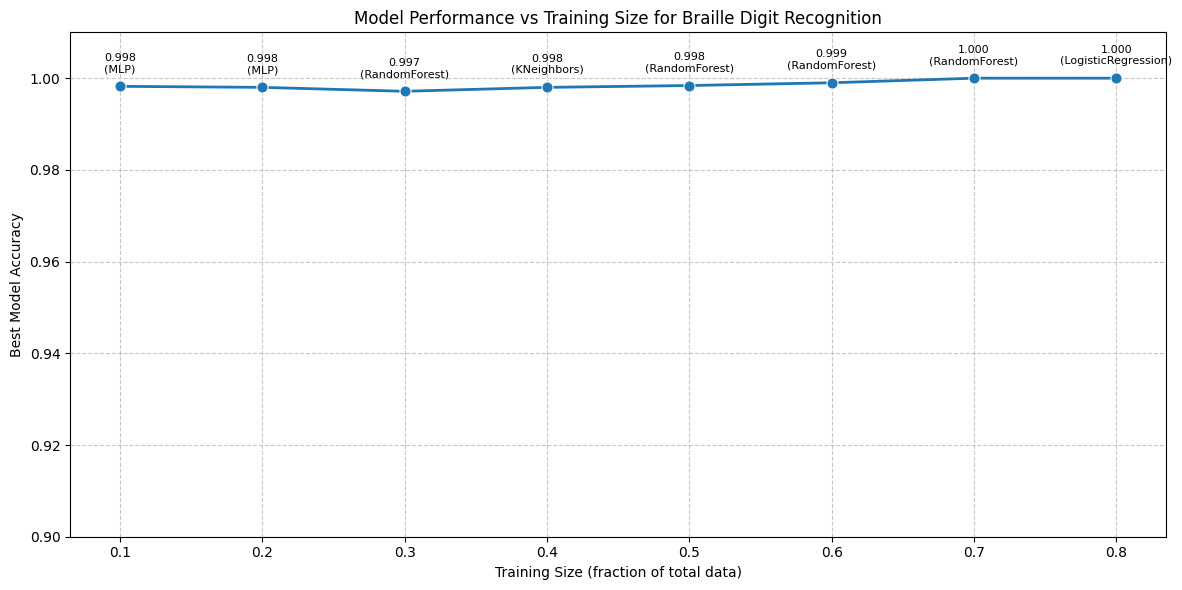

In [6]:
# Visualize performance vs training size
train_sizes = [1 - size for size in best_scores.keys()]
scores = [best_scores[size][0] for size in best_scores.keys()]
models = [best_scores[size][1] for size in best_scores.keys()]

plt.figure(figsize=(12, 6))
sns.lineplot(x=train_sizes, y=scores, marker='o', markersize=8, linewidth=2)

# Add annotations for best model at each point
for i, (train_size, score, model) in enumerate(zip(train_sizes, scores, models)):
    plt.annotate(f'{score:.3f}\n({model})', 
                (train_size, score), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8)

plt.title('Model Performance vs Training Size for Braille Digit Recognition')
plt.xlabel('Training Size (fraction of total data)')
plt.ylabel('Best Model Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.9, 1.01)
plt.tight_layout()
plt.show()

In [8]:
# Prepare data with standardization
x_dataset, y_dataset = make_dataset()
scaler = StandardScaler()
x_dataset_scaled = scaler.fit_transform(x_dataset)

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    x_dataset_scaled, y_dataset, test_size=0.5, random_state=42
)

# Train a MLP model
clf_final = MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(20, 15))
clf_final.fit(x_train, y_train)

# Evaluate
train_score = clf_final.score(x_train, y_train)
test_score = clf_final.score(x_test, y_test)

print(f"Final Model: Multi-Layer Perceptron")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Get predictions
y_pred = clf_final.predict(x_test)

Final Model: Multi-Layer Perceptron
Training Accuracy: 1.0000
Testing Accuracy: 0.9960


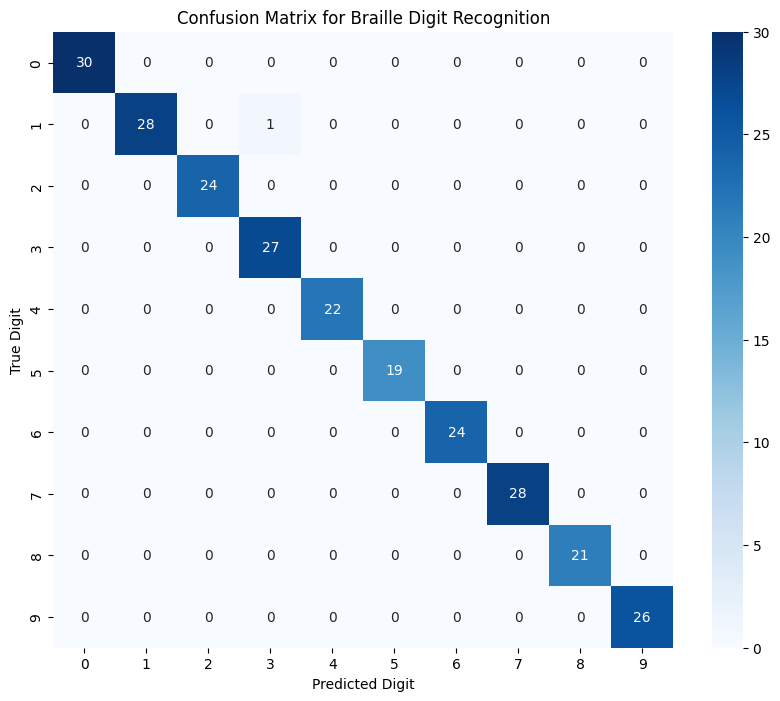

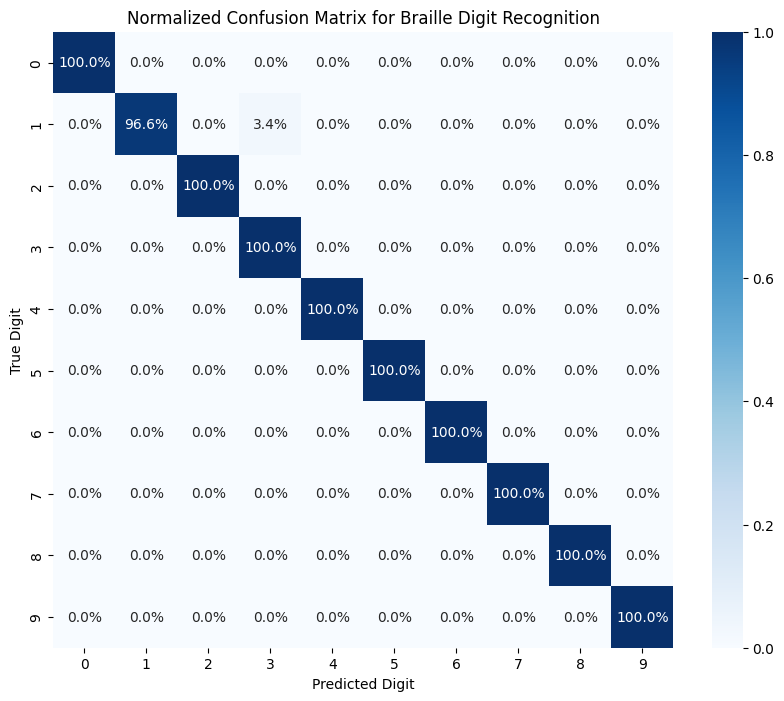


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.97      0.98        29
           2       1.00      1.00      1.00        24
           3       0.96      1.00      0.98        27
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        26

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [10]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for Braille Digit Recognition')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.show()

# Normalized confusion matrix (as percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Normalized Confusion Matrix for Braille Digit Recognition')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))